In [ ]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import torch

# Modify this for your machine
DEVICE = "cuda" if torch.cuda.is_available() else "mps"

train_df = pd.read_pickle("train_df.pkl")
val_df = pd.read_pickle("val_df.pkl")
test_df = pd.read_pickle("test_data.pkl")

INPUT_LENGTH = 9000
BATCH_SIZE = 64
EPOCHS = 20
NUM_WORKERS = 2 if DEVICE == "cuda" else 0
NUM_CLASSES = 4

N_FFT = 256
HOP_LENGTH = 128
HIDDEN_SIZE = 128


CLASS_NAMES = {0: "Normal", 1: "AF", 2: "Other", 3: "Noisy"}


TRAINING_MEAN = 1.07e-09
TRAINING_STD = 175.11


def set_seed(seed=42):
    random.seed(seed)  # Python random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
print("Seed set for reproducibility.")

Seed set for reproducibility.


In [ ]:
# Augmentation functions
import scipy.signal
import torch
import numpy as np
import random
from torch.nn.utils.rnn import pack_sequence

# wrapping them in nn.Module should not introduce huge overhead


def time_shift(signal, shift_range=(-100, 100)):
    shift = np.roll(signal, shift=random.randint(shift_range[0], shift_range[1]))
    return shift


def add_noise(signal, noise_level=0.1):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise


def time_warp(signal, warp_factor=0.1):
    return scipy.signal.resample(
        signal, int(len(signal) * (1 + np.random.uniform(-warp_factor, warp_factor)))
    )


def amplitude_scaling(signal, scale_range=(0.8, 1.2)):
    scale = random.uniform(scale_range[0], scale_range[1])
    return signal * scale


def augment(signal, augmentation="all"):
    if augmentation in ("all", "warp_only") and np.random.rand() < 0.5:
        signal = time_warp(signal)
    if augmentation in ("all", "noise_only") and np.random.rand() < 0.5:
        signal = add_noise(signal)
    if augmentation in ("all", "shift_only") and np.random.rand() < 0.5:
        signal = time_shift(signal)
    if augmentation in ("all", "scale_only") and np.random.rand() < 0.5:
        signal = amplitude_scaling(signal)
    return signal


class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=None):
        self.df = df
        self.augmentation = augmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx]["signal"]
        signal = np.array(signal, dtype=np.float32)
        signal = augment(signal, self.augmentation) 
        
        signal = (signal - TRAINING_MEAN) / TRAINING_STD
        signal = torch.tensor(signal, dtype=torch.float32)

        label = int(self.df.iloc[idx]["label"])
        label = torch.tensor(label, dtype=torch.long)

        length = len(signal)

        return signal, label, length


def collate_fn(batch):
    # TODO: Optimization: sort by length
    signals, labels, lengths = zip(*batch)
    signals = [s.unsqueeze(-1) if s.dim() == 1 else s for s in signals]
    packed_signals = pack_sequence(signals, enforce_sorted=False)

    lengths = torch.tensor(lengths, dtype=torch.int64)
    labels = torch.stack(labels)

    return packed_signals, labels, lengths

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


@torch.jit.script
def batch_apply_stft(
    signals: torch.Tensor, 
    lengths: torch.Tensor, 
    n_fft: int = N_FFT,  
    hop_length: int = HOP_LENGTH,  
    pad_mode: str = "constant"
) -> tuple[torch.Tensor, torch.Tensor]:

    batch_stft = torch.stft(
        signals.squeeze(-1),
        n_fft,
        hop_length,
        window=torch.hann_window(n_fft, device=signals.device),
        pad_mode=pad_mode,
        return_complex=True,
    )
    magnitude = torch.abs(batch_stft)

    new_lengths = torch.clamp((lengths - n_fft) // hop_length + 1, min=1)

    return magnitude, new_lengths

def he_init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

In [64]:
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence


class VorgabeRNN(nn.Module):

    def __init__(
        self,
        hidden_size=HIDDEN_SIZE,
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        dropout_rate=0.2,
    ):
        super(VorgabeRNN, self).__init__()

        # STFT parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_freqs = n_fft // 2 + 1

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        self.conv_output_size = 64 * (self.n_freqs // 4)

        self.rnn = nn.RNN(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.stft = batch_apply_stft
        self.apply(he_init_weights)

        self.rnn_type = "RNN"

    def feature_extractor(self, x: PackedSequence, lengths: torch.Tensor) -> torch.Tensor:
        lengths = lengths.detach().clone().cpu()

        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        x, new_lengths = self.stft(
            x, lengths, n_fft=self.n_fft, hop_length=self.hop_length
        )

        x = torch.log2(x + 1e-8)
        x = x.unsqueeze(1)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        batch_size, channels, freq_bins, time_frames = x.shape
        x = x.view(batch_size, time_frames, -1)

        new_lengths = new_lengths // 4  # lengths after 2 max pooling
        new_lengths = torch.clamp(
            new_lengths, min=1
        )  # avoids zero lengths, shouldn't be necessary

        x = torch.nn.utils.rnn.pack_padded_sequence(
            x, new_lengths, batch_first=True, enforce_sorted=False
        )

        if self.rnn_type == "LSTM":
            LSTM_output, LSTM_states = self.rnn(x)
            return LSTM_states[0][-1]
        else:
            RNN_output, RNN_states = self.rnn(x)
            return RNN_states[-1]

    def forward(self, x: PackedSequence, lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x, lengths)
        x = self.fc(x)
        return x

    def predict(self, x: PackedSequence, lengths: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.forward(x, lengths)
            _, predicted = torch.max(x, 1)
        return predicted

In [65]:
class VorgabeLSTM(VorgabeRNN):

    def __init__(
        self,
        hidden_size=HIDDEN_SIZE,
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        dropout_rate=0.2,
    ):
        super().__init__(hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate)
        self.rnn = nn.LSTM(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.rnn_type = "LSTM"


class VorgabeGRU(VorgabeRNN):

    def __init__(
        self,
        hidden_size=HIDDEN_SIZE,
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        dropout_rate=0.2,
    ):
        super().__init__(hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate)
        self.rnn = nn.GRU(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.rnn_type = "GRU"

In [ ]:
import sklearn.svm
class RNNwithSVM(VorgabeRNN):
    def __init__(
        self,
        hidden_size=HIDDEN_SIZE, # Use global HIDDEN_SIZE as default
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        dropout_rate=0.2,
    ):
        super(RNNwithSVM, self).__init__(
            hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate
        )
        self.fc1 = nn.Linear(hidden_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.svm = sklearn.svm.SVC()
        self.is_svm_trained = False

    def forward(self, x: PackedSequence, lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x, lengths)
        x = self.fc1(x)
        if self.fc2 is not None and not self.is_svm_trained:
            return self.fc2(x)
        return x

    def predict(self, x: PackedSequence, lengths: torch.Tensor) -> torch.Tensor:
        if not self.is_svm_trained:
            raise ValueError("SVM not trained yet!")
        self.eval()
        with torch.no_grad():
            x = self.feature_extractor(x, lengths) 
            x = self.fc1(x)
            x = self.svm.predict(x.cpu().numpy())
        return x
    def _remove_temp_classifier(self):
        self.fc2 = None

In [67]:
from torch.utils.data import DataLoader

train_dataset = ECGDataset(train_df, augmentation=None)
val_dataset = ECGDataset(val_df)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    generator=torch.Generator().manual_seed(42),
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)

# check the actual signal lengths from the paddedsequences after   x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
for signals, labels, lengths in val_loader:
    print(f"Batch size: {signals.batch_sizes}")
    print(f"Signal lengths: {lengths}")
    # signals is a PackedSequence
    print(f"Signal shapes: {[s.shape for s in signals]}")  # Print shapes of each signal in the batch
    x, _ = torch.nn.utils.rnn.pad_packed_sequence(signals, batch_first=True)
    print(f"padded signal lengths: {x.shape[1]}")
    x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
    print(f"packed seq lengths: {x.batch_sizes}")
    print(f"actual signal lengths: {x.data.shape[1]}")
    break

Batch size: tensor([64, 64, 64,  ..., 10, 10, 10])
Signal lengths: tensor([18000,  9000,  9000,  9000,  9000,  4500,  9000, 14648, 11520,  9000,
         8226,  5834,  9000,  9000,  9000,  9000,  9000,  9000,  9000, 18000,
         9000,  9000, 18000,  9000,  9000, 10582,  9000,  9000,  9000,  9000,
         9000,  9000,  9000, 18000,  9000,  9000,  9000, 18000, 18000,  9000,
        18000, 18000,  9000,  9000,  9000,  9000,  9000,  9000,  9000,  9000,
         9000,  6162,  9000,  9000,  9000,  9000,  9000,  9000,  9000, 18000,
         9000,  9000, 18000,  9000])
Signal shapes: [torch.Size([664472, 1]), torch.Size([18000]), torch.Size([64]), torch.Size([64])]
padded signal lengths: 18000
packed seq lengths: tensor([64, 64, 64,  ..., 10, 10, 10])
actual signal lengths: 1


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from sklearn.utils.class_weight import compute_class_weight



def train_model(model, train_loader, epochs=10, lr=0.001, batch_size_factor=4):
    device = "cuda" if torch.cuda.is_available() else "mps"
    model.to(device)

    is_nn_svm = hasattr(model, "svm")

    optimizer = optim.Adam(model.parameters(), lr=lr)

    original_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.array([0, 1, 2, 3]),
        y=train_df["label"].values,
    )

    # Normalize and scale the weights
    scaled_weights = original_weights / original_weights.max()  # normalize to max=1
    scaled_weights = 0.5 + (
        scaled_weights * 0.5
    )  # shrink range to [0.5, 1.0] for balance

    weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32).to(device)


    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    print(f"Training {model.rnn_type}...")
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for signals, labels, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            signals, labels, lengths = signals.to(device), labels.to(device), lengths.to(device)

            optimizer.zero_grad()
            outputs = model(signals, lengths)
            loss = criterion(outputs, labels)

            # ADDED: gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100.0 * correct / total
        print(
            f"Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%"
        )

    if is_nn_svm:
        model._remove_temp_classifier()
        _train_svm_phase(model, train_loader, device, batch_size_factor)

    return model



def _train_svm_phase(model, train_loader, device, batch_size_factor):

    print("Training SVM...")
    model.eval()
    all_features, all_labels = [], []
    batch_features, batch_labels = [], []
    assert model.fc2 is None, "Temporary classifier should be removed before SVM training"

    # extract_features_from_loader(model, data_loader, device):
    with torch.no_grad():
        for signals, labels, lengths in tqdm(train_loader, desc="Extracting features"):
            signals, lengths = signals.to(device), lengths.to(device)
            features = model(signals, lengths)

            batch_features.append(features)
            batch_labels.append(labels)

            if len(batch_features) >= batch_size_factor:
                combined_features = torch.cat(batch_features, dim=0).cpu().numpy()
                combined_labels = torch.cat(batch_labels, dim=0).numpy()
                all_features.append(combined_features)
                all_labels.append(combined_labels)
                batch_features, batch_labels = [], []


    if batch_features:
        combined_features = torch.cat(batch_features, dim=0).cpu().numpy()
        combined_labels = torch.cat(batch_labels, dim=0).numpy()
        all_features.append(combined_features)
        all_labels.append(combined_labels)

    final_features = np.concatenate(all_features, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)

    print(f"Training SVM on {len(final_features)} samples")
    model.svm.fit(final_features, final_labels)
    model.is_svm_trained = True

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


def evaluate_model(model, val_loader, device):
    print("Evaluating model...")
    model.eval()
    all_predictions, all_labels = [], []
    is_nn_svm = hasattr(model, "svm")

    with torch.no_grad():
        for signals, labels, lengths in tqdm(val_loader, desc="Evaluating"):
            signals, lengths = (
                signals.to(device),
                lengths.to(device),
            )

            predictions = model.predict(signals, lengths)
            if not is_nn_svm:
                predictions = predictions.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Final Validation Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_predictions))

    f1 = f1_score(all_labels, all_predictions, average="weighted")
    print(f"Final Validation F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_predictions)
    # normalize heatmap colors in each row for class distribution
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=CLASS_NAMES.values(),
        yticklabels=CLASS_NAMES.values(),
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy

In [70]:
import torch

input_shape = (BATCH_SIZE, INPUT_LENGTH, 1)

for model in [VorgabeRNN, VorgabeLSTM, VorgabeGRU]:

    model_instance = model(
        hidden_size=HIDDEN_SIZE,
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        dropout_rate=0.2,
    )
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_instance = model_instance.to(device)
    model_instance.eval()

    dummy_input = torch.randn(*input_shape, device=device)
    dummy_input = pack_sequence(
        [dummy_input] * input_shape[0], enforce_sorted=False
    )
    dummy_lengths = torch.tensor(
        [input_shape[1]] * input_shape[0], dtype=torch.int64, device=device
    )
    scripted = torch.jit.script(model_instance)
    print(scripted.graph)
    scripted.save(f"{model.__name__}.pt")

graph(%self : __torch__.___torch_mangle_14.VorgabeRNN,
      %x.1 : NamedTuple(data : Tensor, batch_sizes : Tensor, sorted_indices : Tensor?, unsorted_indices : Tensor?),
      %lengths.1 : Tensor):
  %x.5 : Tensor = prim::CallMethod[name="feature_extractor"](%self, %x.1, %lengths.1) # /tmp/ipython-input-64-3004961502.py:75:12
  %fc : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%self)
  %x.9 : Tensor = prim::CallMethod[name="forward"](%fc, %x.5) # /tmp/ipython-input-64-3004961502.py:76:12
  return (%x.9)

graph(%self : __torch__.___torch_mangle_15.VorgabeLSTM,
      %x.1 : NamedTuple(data : Tensor, batch_sizes : Tensor, sorted_indices : Tensor?, unsorted_indices : Tensor?),
      %lengths.1 : Tensor):
  %x.5 : Tensor = prim::CallMethod[name="feature_extractor"](%self, %x.1, %lengths.1) # /tmp/ipython-input-64-3004961502.py:75:12
  %fc : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%self)
  %x.9 : Tensor = prim::CallMethod[name="forward"](%

In [71]:
def check_gradients(model):
    model.train()
    device = next(model.parameters()).device

    dummy_sequences = []
    for i in range(BATCH_SIZE):
        seq = torch.randn(
            1000, 1, device=device, requires_grad=True
        )
        dummy_sequences.append(seq)

    dummy_input = pack_sequence(dummy_sequences, enforce_sorted=False)
    dummy_lengths = torch.tensor(
        [1000] * BATCH_SIZE, dtype=torch.int64, device=device
    )

    output = model(dummy_input, dummy_lengths)
    loss = output.sum()
    loss.backward()

    for name, param in model.named_parameters():
        if param.grad is not None:
            if param.grad.abs().sum() == 0:
                print(f"Gradients for {name} are zero.")


for model in [VorgabeRNN, VorgabeLSTM, VorgabeGRU]:
    model_instance = model(
        hidden_size=HIDDEN_SIZE,
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        dropout_rate=0.2,
    )
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_instance = model_instance.to(device)
    check_gradients(model_instance)

Gradients for rnn.weight_hh_l0 are zero.
Gradients for rnn.weight_hh_l1 are zero.
Gradients for rnn.weight_hh_l0 are zero.
Gradients for rnn.weight_hh_l1 are zero.
Gradients for rnn.weight_hh_l0 are zero.
Gradients for rnn.weight_hh_l1 are zero.


Starting tests with different configurations...
Testing RNNwithSVM with all
Training RNN...


Epoch 1/20: 100%|██████████| 83/83 [00:08<00:00,  9.58it/s]


Epoch 1: Train Loss: 1.1289, Train Acc: 58.68%


Epoch 2/20: 100%|██████████| 83/83 [00:06<00:00, 12.34it/s]


Epoch 2: Train Loss: 1.1155, Train Acc: 58.91%


Epoch 3/20: 100%|██████████| 83/83 [00:07<00:00, 10.42it/s]


Epoch 3: Train Loss: 1.1079, Train Acc: 58.91%


Epoch 4/20: 100%|██████████| 83/83 [00:06<00:00, 12.61it/s]


Epoch 4: Train Loss: 1.1036, Train Acc: 58.83%


Epoch 5/20: 100%|██████████| 83/83 [00:07<00:00, 10.44it/s]


Epoch 5: Train Loss: 1.0909, Train Acc: 58.66%


Epoch 6/20: 100%|██████████| 83/83 [00:07<00:00, 10.73it/s]


Epoch 6: Train Loss: 1.0985, Train Acc: 58.19%


Epoch 7/20: 100%|██████████| 83/83 [00:10<00:00,  7.87it/s]


Epoch 7: Train Loss: 1.0948, Train Acc: 58.63%


Epoch 8/20: 100%|██████████| 83/83 [00:07<00:00, 11.54it/s]


Epoch 8: Train Loss: 1.0777, Train Acc: 58.43%


Epoch 9/20: 100%|██████████| 83/83 [00:07<00:00, 11.55it/s]


Epoch 9: Train Loss: 1.0742, Train Acc: 58.51%


Epoch 10/20: 100%|██████████| 83/83 [00:08<00:00,  9.99it/s]


Epoch 10: Train Loss: 1.0718, Train Acc: 58.64%


Epoch 11/20: 100%|██████████| 83/83 [00:06<00:00, 12.19it/s]


Epoch 11: Train Loss: 1.0676, Train Acc: 58.53%


Epoch 12/20: 100%|██████████| 83/83 [00:08<00:00,  9.79it/s]


Epoch 12: Train Loss: 1.0677, Train Acc: 58.34%


Epoch 13/20: 100%|██████████| 83/83 [00:06<00:00, 11.98it/s]


Epoch 13: Train Loss: 1.0674, Train Acc: 58.66%


Epoch 14/20: 100%|██████████| 83/83 [00:08<00:00,  9.72it/s]


Epoch 14: Train Loss: 1.0749, Train Acc: 58.11%


Epoch 15/20: 100%|██████████| 83/83 [00:06<00:00, 12.54it/s]


Epoch 15: Train Loss: 1.0748, Train Acc: 58.28%


Epoch 16/20: 100%|██████████| 83/83 [00:08<00:00,  9.72it/s]


Epoch 16: Train Loss: 1.0912, Train Acc: 58.43%


Epoch 17/20: 100%|██████████| 83/83 [00:06<00:00, 12.33it/s]


Epoch 17: Train Loss: 1.0874, Train Acc: 58.49%


Epoch 18/20: 100%|██████████| 83/83 [00:08<00:00,  9.91it/s]


Epoch 18: Train Loss: 1.0787, Train Acc: 58.34%


Epoch 19/20: 100%|██████████| 83/83 [00:06<00:00, 12.68it/s]


Epoch 19: Train Loss: 1.0682, Train Acc: 58.38%


Epoch 20/20: 100%|██████████| 83/83 [00:08<00:00,  9.51it/s]


Epoch 20: Train Loss: 1.0662, Train Acc: 58.28%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:05<00:00, 14.44it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]


Final Validation Accuracy: 0.5868
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.00      0.00      0.00        35

    accuracy                           0.59       927
   macro avg       0.15      0.25      0.18       927
weighted avg       0.34      0.59      0.43       927

Final Validation F1 Score: 0.4340


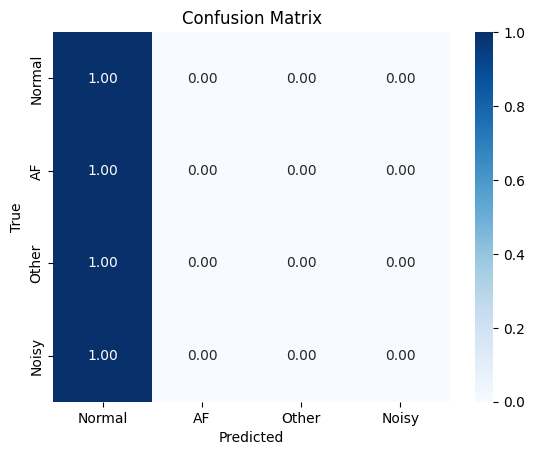

Validation Accuracy of RNNwithSVM with all: 0.5868

Testing VorgabeLSTM with all
Training LSTM...


Epoch 1/20: 100%|██████████| 83/83 [00:06<00:00, 12.21it/s]


Epoch 1: Train Loss: 1.1590, Train Acc: 54.47%


Epoch 2/20: 100%|██████████| 83/83 [00:08<00:00,  9.86it/s]


Epoch 2: Train Loss: 1.0830, Train Acc: 58.49%


Epoch 3/20: 100%|██████████| 83/83 [00:06<00:00, 12.28it/s]


Epoch 3: Train Loss: 1.0845, Train Acc: 58.21%


Epoch 4/20: 100%|██████████| 83/83 [00:08<00:00, 10.07it/s]


Epoch 4: Train Loss: 1.0737, Train Acc: 58.13%


Epoch 5/20: 100%|██████████| 83/83 [00:06<00:00, 12.31it/s]


Epoch 5: Train Loss: 1.0558, Train Acc: 57.48%


Epoch 6/20: 100%|██████████| 83/83 [00:08<00:00,  9.84it/s]


Epoch 6: Train Loss: 1.0424, Train Acc: 57.84%


Epoch 7/20: 100%|██████████| 83/83 [00:06<00:00, 11.88it/s]


Epoch 7: Train Loss: 1.0317, Train Acc: 58.26%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.54it/s]


Epoch 8: Train Loss: 1.0202, Train Acc: 59.04%


Epoch 9/20: 100%|██████████| 83/83 [00:08<00:00,  9.87it/s]


Epoch 9: Train Loss: 1.0124, Train Acc: 58.30%


Epoch 10/20: 100%|██████████| 83/83 [00:06<00:00, 12.36it/s]


Epoch 10: Train Loss: 1.0022, Train Acc: 60.43%


Epoch 11/20: 100%|██████████| 83/83 [00:08<00:00,  9.90it/s]


Epoch 11: Train Loss: 0.9909, Train Acc: 60.30%


Epoch 12/20: 100%|██████████| 83/83 [00:07<00:00, 11.11it/s]


Epoch 12: Train Loss: 0.9720, Train Acc: 61.86%


Epoch 13/20: 100%|██████████| 83/83 [00:08<00:00,  9.93it/s]


Epoch 13: Train Loss: 0.9931, Train Acc: 60.51%


Epoch 14/20: 100%|██████████| 83/83 [00:06<00:00, 12.45it/s]


Epoch 14: Train Loss: 0.9775, Train Acc: 60.89%


Epoch 15/20: 100%|██████████| 83/83 [00:08<00:00, 10.18it/s]


Epoch 15: Train Loss: 0.9500, Train Acc: 62.51%


Epoch 16/20: 100%|██████████| 83/83 [00:07<00:00, 10.42it/s]


Epoch 16: Train Loss: 0.9532, Train Acc: 62.24%


Epoch 17/20: 100%|██████████| 83/83 [00:08<00:00, 10.10it/s]


Epoch 17: Train Loss: 0.9484, Train Acc: 61.86%


Epoch 18/20: 100%|██████████| 83/83 [00:08<00:00, 10.23it/s]


Epoch 18: Train Loss: 0.9497, Train Acc: 61.65%


Epoch 19/20: 100%|██████████| 83/83 [00:07<00:00, 11.84it/s]


Epoch 19: Train Loss: 0.9674, Train Acc: 61.35%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.82it/s]


Epoch 20: Train Loss: 0.9566, Train Acc: 61.75%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 18.93it/s]


Final Validation Accuracy: 0.6451
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       544
           1       0.00      0.00      0.00        84
           2       0.45      0.44      0.44       264
           3       0.00      0.00      0.00        35

    accuracy                           0.65       927
   macro avg       0.29      0.33      0.31       927
weighted avg       0.55      0.65      0.59       927

Final Validation F1 Score: 0.5940


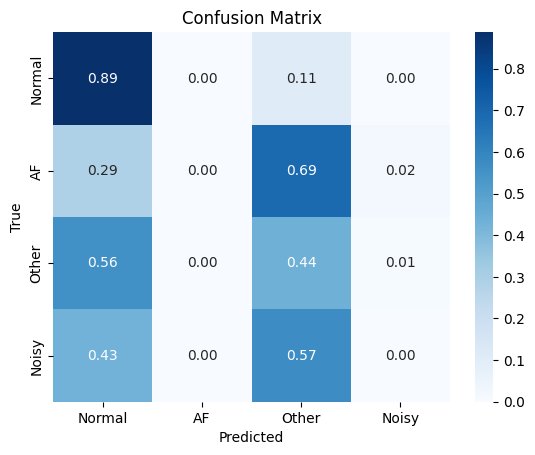

Validation Accuracy of VorgabeLSTM with all: 0.6451

Testing VorgabeGRU with all
Training GRU...


Epoch 1/20: 100%|██████████| 83/83 [00:07<00:00, 11.58it/s]


Epoch 1: Train Loss: 1.6497, Train Acc: 45.32%


Epoch 2/20: 100%|██████████| 83/83 [00:08<00:00,  9.87it/s]


Epoch 2: Train Loss: 1.2719, Train Acc: 49.52%


Epoch 3/20: 100%|██████████| 83/83 [00:06<00:00, 12.16it/s]


Epoch 3: Train Loss: 1.2559, Train Acc: 49.26%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 4: Train Loss: 1.2363, Train Acc: 48.46%


Epoch 5/20: 100%|██████████| 83/83 [00:08<00:00,  9.67it/s]


Epoch 5: Train Loss: 1.1222, Train Acc: 54.00%


Epoch 6/20: 100%|██████████| 83/83 [00:06<00:00, 12.18it/s]


Epoch 6: Train Loss: 1.0866, Train Acc: 57.43%


Epoch 7/20: 100%|██████████| 83/83 [00:08<00:00,  9.90it/s]


Epoch 7: Train Loss: 1.0857, Train Acc: 56.84%


Epoch 8/20: 100%|██████████| 83/83 [00:07<00:00, 11.25it/s]


Epoch 8: Train Loss: 1.0423, Train Acc: 58.42%


Epoch 9/20: 100%|██████████| 83/83 [00:08<00:00, 10.15it/s]


Epoch 9: Train Loss: 1.0141, Train Acc: 60.53%


Epoch 10/20: 100%|██████████| 83/83 [00:06<00:00, 12.35it/s]


Epoch 10: Train Loss: 0.9969, Train Acc: 60.59%


Epoch 11/20: 100%|██████████| 83/83 [00:08<00:00, 10.02it/s]


Epoch 11: Train Loss: 1.0045, Train Acc: 60.57%


Epoch 12/20: 100%|██████████| 83/83 [00:06<00:00, 12.68it/s]


Epoch 12: Train Loss: 0.9768, Train Acc: 61.69%


Epoch 13/20: 100%|██████████| 83/83 [00:08<00:00, 10.13it/s]


Epoch 13: Train Loss: 0.9634, Train Acc: 62.68%


Epoch 14/20: 100%|██████████| 83/83 [00:06<00:00, 12.34it/s]


Epoch 14: Train Loss: 0.9643, Train Acc: 62.03%


Epoch 15/20: 100%|██████████| 83/83 [00:08<00:00, 10.21it/s]


Epoch 15: Train Loss: 0.9524, Train Acc: 62.89%


Epoch 16/20: 100%|██████████| 83/83 [00:07<00:00, 11.57it/s]


Epoch 16: Train Loss: 0.9310, Train Acc: 62.20%


Epoch 17/20: 100%|██████████| 83/83 [00:07<00:00, 10.97it/s]


Epoch 17: Train Loss: 0.9341, Train Acc: 63.16%


Epoch 18/20: 100%|██████████| 83/83 [00:07<00:00, 11.11it/s]


Epoch 18: Train Loss: 0.9353, Train Acc: 63.86%


Epoch 19/20: 100%|██████████| 83/83 [00:07<00:00, 11.64it/s]


Epoch 19: Train Loss: 0.9302, Train Acc: 63.10%


Epoch 20/20: 100%|██████████| 83/83 [00:08<00:00, 10.20it/s]


Epoch 20: Train Loss: 0.9098, Train Acc: 63.37%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


Final Validation Accuracy: 0.5933
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       544
           1       0.24      0.18      0.21        84
           2       0.42      0.61      0.49       264
           3       0.00      0.00      0.00        35

    accuracy                           0.59       927
   macro avg       0.36      0.37      0.36       927
weighted avg       0.60      0.59      0.59       927

Final Validation F1 Score: 0.5893


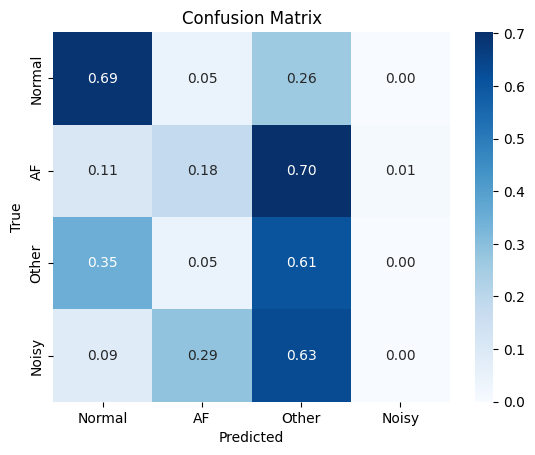

Validation Accuracy of VorgabeGRU with all: 0.5933

Testing VorgabeRNN with all
Training RNN...


Epoch 1/20: 100%|██████████| 83/83 [00:06<00:00, 12.87it/s]


Epoch 1: Train Loss: 1.9667, Train Acc: 45.87%


Epoch 2/20: 100%|██████████| 83/83 [00:08<00:00, 10.09it/s]


Epoch 2: Train Loss: 1.2175, Train Acc: 54.42%


Epoch 3/20: 100%|██████████| 83/83 [00:06<00:00, 13.08it/s]


Epoch 3: Train Loss: 1.1259, Train Acc: 57.86%


Epoch 4/20: 100%|██████████| 83/83 [00:08<00:00, 10.03it/s]


Epoch 4: Train Loss: 1.1113, Train Acc: 58.89%


Epoch 5/20: 100%|██████████| 83/83 [00:06<00:00, 12.63it/s]


Epoch 5: Train Loss: 1.1049, Train Acc: 58.89%


Epoch 6/20: 100%|██████████| 83/83 [00:08<00:00, 10.26it/s]


Epoch 6: Train Loss: 1.1019, Train Acc: 58.91%


Epoch 7/20: 100%|██████████| 83/83 [00:06<00:00, 12.54it/s]


Epoch 7: Train Loss: 1.1048, Train Acc: 58.85%


Epoch 8/20: 100%|██████████| 83/83 [00:08<00:00, 10.19it/s]


Epoch 8: Train Loss: 1.1033, Train Acc: 58.85%


Epoch 9/20: 100%|██████████| 83/83 [00:06<00:00, 12.82it/s]


Epoch 9: Train Loss: 1.1126, Train Acc: 58.83%


Epoch 10/20: 100%|██████████| 83/83 [00:08<00:00, 10.01it/s]


Epoch 10: Train Loss: 1.1049, Train Acc: 58.87%


Epoch 11/20: 100%|██████████| 83/83 [00:06<00:00, 12.47it/s]


Epoch 11: Train Loss: 1.0961, Train Acc: 58.83%


Epoch 12/20: 100%|██████████| 83/83 [00:08<00:00, 10.02it/s]


Epoch 12: Train Loss: 1.1080, Train Acc: 58.93%


Epoch 13/20: 100%|██████████| 83/83 [00:06<00:00, 12.67it/s]


Epoch 13: Train Loss: 1.1072, Train Acc: 58.93%


Epoch 14/20: 100%|██████████| 83/83 [00:08<00:00, 10.03it/s]


Epoch 14: Train Loss: 1.1016, Train Acc: 58.83%


Epoch 15/20: 100%|██████████| 83/83 [00:06<00:00, 12.40it/s]


Epoch 15: Train Loss: 1.1012, Train Acc: 58.82%


Epoch 16/20: 100%|██████████| 83/83 [00:07<00:00, 10.55it/s]


Epoch 16: Train Loss: 1.0930, Train Acc: 58.89%


Epoch 17/20: 100%|██████████| 83/83 [00:07<00:00, 11.81it/s]


Epoch 17: Train Loss: 1.0963, Train Acc: 58.80%


Epoch 18/20: 100%|██████████| 83/83 [00:07<00:00, 10.94it/s]


Epoch 18: Train Loss: 1.0923, Train Acc: 58.82%


Epoch 19/20: 100%|██████████| 83/83 [00:07<00:00, 11.42it/s]


Epoch 19: Train Loss: 1.0977, Train Acc: 58.91%


Epoch 20/20: 100%|██████████| 83/83 [00:07<00:00, 11.43it/s]


Epoch 20: Train Loss: 1.0954, Train Acc: 58.83%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 20.03it/s]


Final Validation Accuracy: 0.5804
              precision    recall  f1-score   support

           0       0.59      0.99      0.73       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.17      0.06      0.09        35

    accuracy                           0.58       927
   macro avg       0.19      0.26      0.20       927
weighted avg       0.35      0.58      0.43       927

Final Validation F1 Score: 0.4344


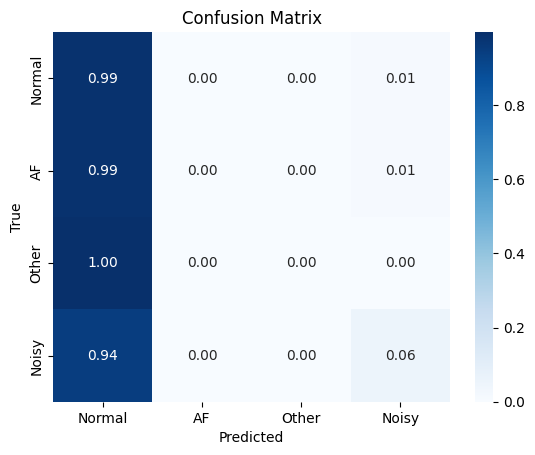

Validation Accuracy of VorgabeRNN with all: 0.5804

All tests completed.
Best Model: VorgabeLSTM, Augmentation: all, Accuracy: 0.6451


In [72]:
test_space = {
    "model": [RNNwithSVM,VorgabeLSTM, VorgabeGRU, VorgabeRNN ],
    "augmentation": ["all"],
}

results = []
print("Starting tests with different configurations...")

for aug in test_space["augmentation"]:
    train_set = ECGDataset(train_df, augmentation=aug)
    val_set = ECGDataset(val_df)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(42), num_workers=NUM_WORKERS, collate_fn=collate_fn)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

    for model_cls in test_space["model"]:
        print(f"Testing {model_cls.__name__} with {aug}")
        model = model_cls(
            hidden_size=HIDDEN_SIZE,
            num_layers=2,
            num_classes=NUM_CLASSES,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            dropout_rate=0.2,
        )
        device = "cuda" if torch.cuda.is_available() else "mps"
        model = model.to(device)
        trained = train_model(model, train_loader, epochs=EPOCHS, lr=0.001, batch_size_factor=4)
        acc = evaluate_model(trained, val_loader, device)

        print(f"Validation Accuracy of {model_cls.__name__} with {aug}: {acc:.4f}\n")
        results.append({"model": model_cls.__name__, "augmentation": aug, "accuracy": acc})
        del trained
        torch.cuda.empty_cache()

    del train_set, val_set, train_loader, val_loader

print("All tests completed.")
best = max(results, key=lambda x: x["accuracy"])
print(f"Best Model: {best['model']}, Augmentation: {best['augmentation']}, Accuracy: {best['accuracy']:.4f}")